# Heat Wave Equation 2D
### Daniele Fazzari - University of Naples Federico II & Universidad de Granada


The heat equation in 2D can be written as follows (where $u$ is the temperature, and $\kappa$ is the material specific heat conduction constant):
$$
\begin{align}
\frac{\partial u}{\partial t} &= \kappa \nabla^2 u =\kappa \left[ \frac{\partial^2 u}{\partial x^2} +  \frac{\partial^2 u}{\partial y^2} \right]
\end{align}
$$


By approximating the temporal derivative with a forward difference, the spatial derivative with a central difference, and gathering $u^n+1$ on the left hand side and $u^n$on the right, we obtain:
$$
\frac{1}{\Delta t} (u_{i, j}^{n+1} - u_{i, j}^{n}) 
= \kappa \left [
\frac{1}{\Delta x^2}(u_{i-1, j}^n - 2u_{i, j}^n + u_{i+1, j}^n)
+ \frac{1}{\Delta y^2}(u_{i, j-1}^n - 2u_{i, j}^n + u_{i, j+1}^n)
\right]
$$

$$
u^{n+1}_{i,j} = u_{i,j}^n 
+ \frac{\kappa\Delta t}{\Delta x^2}(u_{i-1, j}^n - 2u_{i, j}^n + u_{i+1, j}^n)
+ \frac{\kappa\Delta t}{\Delta y^2}(u_{i, j-1}^n - 2u_{i, j}^n + u_{i, j+1}^n)
$$

The discretization is stable if the following CFL conditions are met: 
$$
\frac{1}{2} < \frac{\kappa\Delta t}{\Delta x^2}, \;\;
\frac{1}{2} < \frac{\kappa\Delta t}{\Delta y^2} \\
$$
or equivalently the following CFL condition:
$$
\Delta t \lt \text{min}\left(\frac{\Delta x^2}{2k}, \frac{\Delta y^2}{2k}\right)
$$

In [1]:
#IMPORTING LIBRARIES

import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from pylab import figure, cm
import pycuda
import pycuda.driver as cuda
from pycuda.compiler import SourceModule
import pycuda.autoinit
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#DEFINING PROBLEM PARAMETERS

BLOCK_SIZE_X=8 #x-dimensionality of the blocks
BLOCK_SIZE_Y=8 #y-dimensionality of the blocks
nx=16 #x-dimensionaly of the object 
ny=16 #y-dimensionaly of the object
kappa=1 #kappa, object diffusion coefficient
dx=1 #discretization step of the x-dimensionality of the object grid 
dy=1 #discretization step of the y-dimensionality of the object grid
dt=0.4*min(dx*dx / (2.0*kappa), dy*dy / (2.0*kappa)) #timestep, calcluted like that to make sure that the evolution is stable 

In [3]:
#KERNEL FUNCTION

heat_eqn_kernel_src = """
__global__ void heatEqn2D( float* u1, float* u0, float kappa, float dt,
            float dx, float dy, unsigned int nx, unsigned int ny) 
{
    int i = blockIdx.x*blockDim.x + threadIdx.x;
    int j = blockIdx.y*blockDim.y + threadIdx.y;
    
    int center = j*nx + i;
    int north =(j+1)*nx+i;
    int south=(j-1)*nx+i;
    int east=j*nx + (i+1);
    int west=j*nx + (i-1);
    
            if(i>0 && i<nx-1 && j>0 && j<ny-1){
                u1[center] = u0[center]
                + (kappa*dt/(dx*dx)) * (u0[west] - 2*u0[center] + u0[east])
                + (kappa*dt/(dy*dy)) * (u0[south]-2*u0[center]+u0[north]);
            }
        
    else{ 
        u1[center] = u0[center];
    }
}
"""

mod = SourceModule(heat_eqn_kernel_src)
heatEqnGPU = mod.get_function("heatEqn2D")

In [4]:
#MAIN CPU PROGRAM

def heatEquationGPU(u0,kappa,dt,dx,dy,num_timesteps):
    
    assert(u0.dtype == np.float32) #assert that we are using single-precision floats   
    u1_gpu = cuda.mem_alloc(u0.nbytes) #making space for u1 on GPU memory
    u0_gpu=cuda.mem_alloc(u0.nbytes) #making space for u0 on GPU memory
    cuda.memcpy_htod(u0_gpu,u0) #copying u0 initial temperatures vector on GPU memory
    
    block=(BLOCK_SIZE_X, BLOCK_SIZE_Y,1) #computing block size. Bidimensional blocks.
    grid=(int(np.ceil(nx/BLOCK_SIZE_X)),int(np.ceil(ny/BLOCK_SIZE_Y)),1) #computing grid size. Bidimensional grid.
                
    for n in range(num_timesteps):  #n is the time-index
        heatEqnGPU(u1_gpu, u0_gpu, np.float32(kappa), np.float32(dt), np.float32(dx),np.float32(dy),np.uint32(nx),np.uint32(nx), block=block, grid=grid)
        u0_gpu, u1_gpu = u1_gpu, u0_gpu  #Swap the new and old temperatures
        
    u_updated = np.empty_like(u0)
    cuda.memcpy_dtoh(u_updated, u0_gpu) #retrieving from GPU memory the updated temperatures at timestep n=num_timesteps
    return u_updated  #Return the updated temperatures
    

In [13]:
#CALLING MAIN PROGRAM 

np.random.seed(50)
initial_temp=np.random.rand(nx*ny).astype(np.float32) #initial pseudo-random temperatures
u_tot_1 = heatEquationGPU(u0=initial_temp.copy(), kappa=kappa,dt=dt,dx=dx,dy=dy,num_timesteps=50)

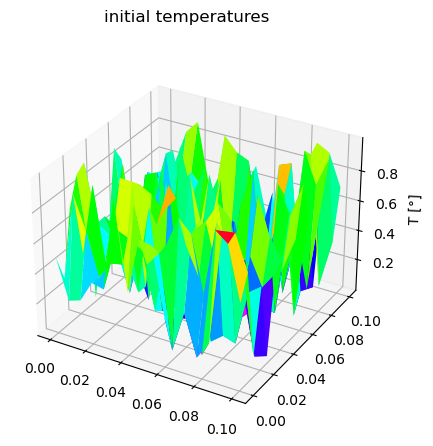

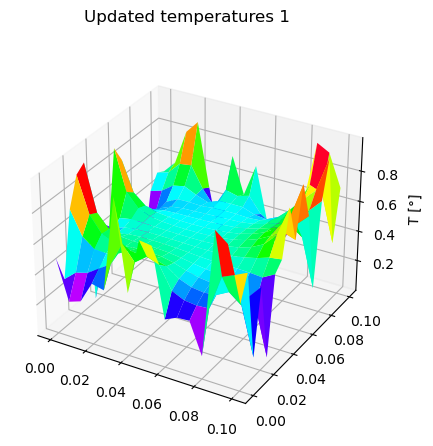

In [14]:
#PLOTTING

updated_temperatures_matrix_1=u_tot_1.reshape(nx,ny)
initial_temperatures_matrix=initial_temp.reshape(nx,ny)

X = np.linspace(0, 0.1, nx, endpoint=True)
Y = np.linspace(0, 0.1, ny, endpoint=True)
X, Y = np.meshgrid(X, Y)

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(X, Y, initial_temperatures_matrix[:,:], cmap = 'gist_rainbow_r', edgecolor = 'none')
ax.set_zlabel('T [°]')
fig.suptitle("initial temperatures")
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.plot_surface(X, Y, updated_temperatures_matrix_1[:,:], cmap = 'gist_rainbow_r', edgecolor = 'none')
ax.set_zlabel('T [°]')
fig.suptitle("Updated temperatures 1")
plt.show()